In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm
%matplotlib inline

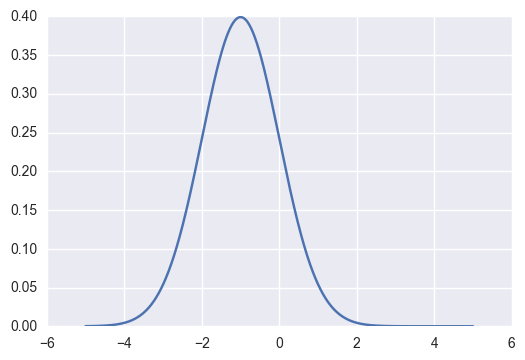

In [2]:
# 平均数
mu = -1 
# 方差
sigma = 1
#横坐标
xs = np.linspace(-5,5,1000)
#作图
plt.plot(xs,norm.pdf(xs,loc=mu,scale=sigma))

In [3]:
# MLP
def mlp(input,output_dim):
    input_size = 1
    #layer1
    w1 = tf.Variable(tf.random_normal(shape=[input_size,6],dtype=tf.float32),name='weights_layer1')
    b1 = tf.Variable(tf.zeros(shape=[input_size,6],dtype=tf.float32),name='biases_layer1')
    fc1 = tf.tanh(tf.add(tf.matmul(input,w1),b1))
    #layer2
    w2 = tf.Variable(tf.random_normal(shape=[6,5],dtype=tf.float32),name='weights_layer2')
    b2 = tf.Variable(tf.zeros(shape=[1,5],dtype=tf.float32),name='biases_layer2')
    fc2 = tf.tanh(tf.add(tf.matmul(fc1,w2),b2))
    print(fc2.get_shape())
    #layer3
    w3 = tf.Variable(tf.random_normal(shape=[5,output_dim],dtype=tf.float32),name='weights_layer3')
    b3 = tf.Variable(tf.zeros(shape=[1,output_dim],dtype=tf.float32),name='biases_layer3')
    fc3 = tf.tanh(tf.add(tf.matmul(fc2,w3),b3))
    
    return fc3,[w1,b1,w2,b2,w3,b3]
    
                     

In [4]:
def momentum_optimizer(loss,var_list):
#     batch = tf.Variable(0)
    optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    return optimizer

In [5]:
M=200
#define the generator
with tf.variable_scope("Generator") as scope:
    z_node = tf.placeholder(tf.float32,shape=(M,1),name='z_node')
    G,theta_g = mlp(z_node,1)
    G = tf.multiply(5.0,G)
    g_sum = tf.summary.scalar('G',G)
#define the discriminator
with tf.variable_scope("Discriminator") as scope:
    x_node = tf.placeholder(tf.float32,shape=(M,1),name='x_node')
    fc,theta_d = mlp(x_node,1)
    D1 = tf.maximum(tf.minimum(fc,0.99),0.01) #? ? ?
    #make a copy of D
    scope.reuse_variables()
    fc,theta_d = mlp(G,1)
    D2 = tf.maximum(tf.minimum(fc,0.00),0.01)

# define the loss func
obj_d = tf.reduce_mean(tf.log(D1)+tf.log(1-D2))
loss_d_sum = tf.summary.scalar('loss_d',obj_d)
obj_g = tf.reduce_mean(tf.log(D2))
loss_g_sum = tf.summary.scalar('loss_g',obj_g)

#define the optimizer 
opt_d = momentum_optimizer(1-obj_d,theta_d)
opt_g = momentum_optimizer(1-obj_g,theta_g) 

(200, 5)
(200, 5)
(200, 5)


In [6]:
# define the training parameter
k=1
iters = 2000
histd, histg= np.zeros(iters), np.zeros(iters)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    writer = tf.summary.FileWriter('logs/',sess.graph) 
    d_result = tf.summary.merge(loss_d_sum)
    g_result = tf.suammry.merge(g_sum)
    # training
    for i in range(iters):
        for j in range(k):
            x = np.random.normal(mu,sigma,M)
            x.sort()
            x_input = np.reshape(x,(M,1))
            z = np.linspace(-5.0,5.0,M) + np.random.random(M)*0.01
            z=np.array(z)
#           print(z.shape)
            z_input = np.reshape(z,(M,1))
            histd[i],_,summary_str=sess.run([obj_d,opt_d,d_result],feed_dict={x_node:x_input,z_node:z_input})
            writer.add_summary(summary_str,i)
        z= np.linspace(-5.0,5.0,M)+np.random.random(M)*0.01 # sample noise prior 
        z_input = np.reshape(z,(M,1))
        histg[i],_,summary_str = sess.run([obj_g,opt_g,g_result],feed_dict={z_node:z_input})       
        writer.add_summary(summary_str,i)


TypeError: 'Tensor' object is not iterable.